In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def allsatsundays(start_date, end_date):
    day_sat = pd.date_range(start=start_date, end=end_date, 
                         freq='W-SAT').strftime('%Y-%m-%d').tolist()
    day_sun = pd.date_range(start=start_date, end=end_date, 
                         freq='W-SUN').strftime('%Y-%m-%d').tolist()
    days = day_sat+day_sun
    days.sort()
    return days

def allsatsundays(start_date, end_date):
    day_sat = pd.date_range(start=start_date, end=end_date, 
                         freq='W-SAT').strftime('%Y-%m-%d').tolist()
    day_sun = pd.date_range(start=start_date, end=end_date, 
                         freq='W-SUN').strftime('%Y-%m-%d').tolist()
    days = day_sat+day_sun
    days.sort()
    return days

def get_stock_market_holydays(filename, start_date, end_date):
    df = pd.read_csv(filename)
    kor_days = df['KOR'][df['KOR'].notnull()].values.tolist()
    usa_days = df['USA'][df['USA'].notnull()].values.tolist() # Nan value를 제외한 값을 리스트로 변환

    holydays = allsatsundays(start_date, end_date)
    
    kor_days = sorted(set(kor_days + holydays))
    usa_days = sorted(set(usa_days + holydays))
    
    return kor_days, usa_days

def get_seq_data(filename, holydays):
    df = pd.read_csv(filename)
    df_seq = df[~df['date'].isin(holydays)].copy()
    df_seq.dropna(subset=df.columns[1:], how='all', inplace=True)
    return df_seq

In [3]:
filename = 'https://raw.githubusercontent.com/fasthill/'\
            'factors_affecting_stock_price/main/data/stock_market_holydays/stock_market_holidays.csv'
start_date = '2020-01-01'
end_date = '2022-12-31'

kor_days, usa_days = get_stock_market_holydays(filename, start_date, end_date) # get stock market holydays

In [4]:
filename = '../data/data_hyunmotor.csv'
df = get_seq_data(filename, kor_days)

In [5]:
df =  df[:-1]
df.tail()

,date,retail,retail_cr,retail_days,foreigner,foreigner_cr,foreigner_days,institution,institution_cr,institution_days,...,rc4_pcr,open,high,low,close,close_cr,vol,vol_cr,high_time,low_time
919,2022-07-08,-20479.0,NaN,NaN,15617.0,NaN,NaN,3853.0,NaN,NaN,...,NaN,177500.0,180500.0,177000.0,178000.0,1.71,147130.0,NaN,NaN,NaN
922,2022-07-11,-10749.0,NaN,NaN,11123.0,NaN,NaN,-719.0,NaN,NaN,...,NaN,180000.0,182000.0,179000.0,179000.0,0.56,119200.0,NaN,NaN,NaN
923,2022-07-12,868.0,NaN,NaN,3282.0,NaN,NaN,-3835.0,NaN,NaN,...,NaN,180000.0,181500.0,177000.0,179000.0,0.00,96440.0,NaN,NaN,NaN
924,2022-07-13,-40414.0,NaN,NaN,18096.0,NaN,NaN,22755.0,NaN,NaN,...,NaN,180000.0,185000.0,178500.0,183500.0,2.51,172566.0,NaN,NaN,NaN
925,2022-07-14,13810.0,NaN,NaN,9619.0,NaN,NaN,-23410.0,NaN,NaN,...,NaN,183000.0,184500.0,180500.0,182500.0,-0.54,142369.0,NaN,NaN,NaN


In [ ]:
import datetime, time
def get_20days_data(series):
    x_num = np.arange(1, 21)
    for i in range(len(series)-600):
        y = series[i:i+20]
        plt.plot(x_num, y)
        plt.show()
        time.sleep(0.3)

In [ ]:
import datetime, time
def get_5days_data(series):
    x_num = np.arange(1, 6) # 과거 5일 데이터
    for i in range(len(series)-610):
        y = series[i:i+5]
        y = y - y.iloc[0]
        plt.plot(x_num, y)

In [ ]:
get_5days_data(df['retail'])

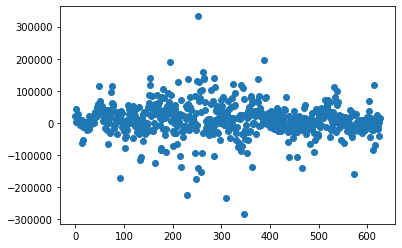

In [39]:
x = np.arange(len(df['retail']))
plt.scatter(x, df['retail'])

In [6]:
def classify_data(df, col_name):
    col_index = df.columns.tolist()
    for i, col in enumerate(col_name):
        mu = df[col].mean()
        sigma = df[col].std()
        df_min = df[col].min()
        df_max = df[col].max()
        cut_div = [df_min, mu - 3*sigma, mu - 2*sigma, mu - sigma, mu - 0.5*sigma, 
                   mu + 0.5*sigma, mu + sigma, mu + 2*sigma, mu + 3*sigma, df_max ]
        ix = i + col_index.index(col)
        df_new = pd.cut(df[col], cut_div, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
        df.insert(ix+1, col+'_class', df_new)
        df[[col, col+'_class']].head()
        
    return df

In [7]:
investors = ['retail', 'foreigner', 'institution', 'financial', 'invtrust', 'pension',
             'privequity', 'bank',  'insurance', 'financeetc', 'corporateetc', 'foreigneretc']
classify_data(df, investors)

,date,retail,retail_class,retail_cr,retail_days,foreigner,foreigner_class,foreigner_cr,foreigner_days,institution,...,rc4_pcr,open,high,low,close,close_cr,vol,vol_cr,high_time,low_time
1,2020-01-02,21980.0,5,NaN,NaN,-14050.0,5,NaN,NaN,-12570.0,...,NaN,121000.0,121000.0,118000.0,118000.0,-2.07,66205.0,NaN,NaN,NaN
2,2020-01-03,42651.0,6,NaN,NaN,-27939.0,4,NaN,NaN,-21214.0,...,NaN,118500.0,119000.0,115000.0,116000.0,-1.69,133657.0,NaN,NaN,NaN
5,2020-01-06,2658.0,5,NaN,NaN,-1144.0,5,NaN,NaN,-5078.0,...,NaN,116000.0,117000.0,115500.0,116000.0,0.00,38907.0,NaN,NaN,NaN
6,2020-01-07,13532.0,5,NaN,NaN,-5817.0,5,NaN,NaN,-11405.0,...,NaN,116500.0,117000.0,115500.0,115500.0,-0.43,78229.0,NaN,NaN,NaN
7,2020-01-08,17848.0,5,NaN,NaN,-1415.0,5,NaN,NaN,-20996.0,...,NaN,115000.0,115500.0,111500.0,112000.0,-3.03,117813.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,2022-07-08,-20479.0,4,NaN,NaN,15617.0,6,NaN,NaN,3853.0,...,NaN,177500.0,180500.0,177000.0,178000.0,1.71,147130.0,NaN,NaN,NaN
922,2022-07-11,-10749.0,5,NaN,NaN,11123.0,6,NaN,NaN,-719.0,...,NaN,180000.0,182000.0,179000.0,179000.0,0.56,119200.0,NaN,NaN,NaN
923,2022-07-12,868.0,5,NaN,NaN,3282.0,5,NaN,NaN,-3835.0,...,NaN,180000.0,181500.0,177000.0,179000.0,0.00,96440.0,NaN,NaN,NaN
924,2022-07-13,-40414.0,4,NaN,NaN,18096.0,6,NaN,NaN,22755.0,...,NaN,180000.0,185000.0,178500.0,183500.0,2.51,172566.0,NaN,NaN,NaN


In [39]:
df.loc[:, ['retail','retail_class', 'foreigner', 'foreigner_class', 'institution', 'institution_class']]

,retail,retail_class,foreigner,foreigner_class,institution,institution_class
1,21980.0,5,-14050.0,5,-12570.0,5
2,42651.0,6,-27939.0,4,-21214.0,4
5,2658.0,5,-1144.0,5,-5078.0,5
6,13532.0,5,-5817.0,5,-11405.0,5
7,17848.0,5,-1415.0,5,-20996.0,4
...,...,...,...,...,...,...
919,-20479.0,4,15617.0,6,3853.0,5
922,-10749.0,5,11123.0,6,-719.0,5
923,868.0,5,3282.0,5,-3835.0,5
924,-40414.0,4,18096.0,6,22755.0,6


In [16]:
a = [0,1,0,1,1,0,0,0,1,1,0,1,0]
b = [0,0,0,0,1,1,0,1,1,1,0,0,0]

y = pd.DataFrame({'a':a, 'b':b})

In [27]:
test = lambda a : 1 if (a > 0) else (if (a < 0) -1 else 0)

SyntaxError: invalid syntax (2666726193.py, line 1)

In [28]:
test = lambda a : 1 if (a > 0) else -1

In [29]:
test(-10)

-1

In [38]:
a += 1
a += 1
a

7

In [42]:
df_temp = df['foreigner'].apply(lambda x : 1 if (x > 0) else -1)

In [43]:
df_temp

1     -1
2     -1
5     -1
6     -1
7     -1
      ..
919    1
922    1
923    1
924    1
925    1
Name: foreigner, Length: 627, dtype: int64

In [47]:
def consecutive_count(sr):
    p_sum = 0
    m_sum = 0
    z_sum = 0
    for i, num in enumerate(sr):
        if (num == 0) & (i == z_sum) :
            z_sum += 1
            continue
        elif (num == 1) & (i == p_sum) :
            p_sum += 1
            continue
        elif (num == -1) & (i == m_sum) :
            m_sum += 1
            continue   
        else :
            return p_sum, m_sum, z_sum       

In [59]:
df_temp = df['insurance'].apply(lambda x : 1 if (x > 0) else -1)

In [86]:
df_temp = [ 1, 1, 1, -1]

In [87]:
x = consecutive_count(df_temp)

In [88]:
x

(3, 0, 0)

In [23]:
y['a'], y['a'].shift()

(0     0
 1     1
 2     0
 3     1
 4     1
 5     0
 6     0
 7     0
 8     1
 9     1
 10    0
 11    1
 12    0
 Name: a, dtype: int64,
 0     NaN
 1     0.0
 2     1.0
 3     0.0
 4     1.0
 5     1.0
 6     0.0
 7     0.0
 8     0.0
 9     1.0
 10    1.0
 11    0.0
 12    1.0
 Name: a, dtype: float64)

In [20]:
y != y.shift()

,a,b
0,True,True
1,True,False
2,True,False
3,True,False
4,False,True
5,True,False
6,False,True
7,False,True
8,True,False
9,False,False


In [12]:
c = lambda y: y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1)
c(y.unstack()).unstack().T

,a,b
0,0,0
1,1,0
2,0,0
3,1,0
4,2,1
5,0,2
6,0,0
7,0,1
8,1,2
9,2,3


In [ ]:
mu = df['retail'].mean()
sigma = df['retail'].std()
df_min = df['retail'].min()
df_max = df['retail'].max()
cut_div = [df_min, mu - 3*sigma, mu - 2*sigma, 
           mu - sigma, mu + sigma, mu + 2*sigma, mu + 3*sigma, df_max ]
df['retail_class'] = pd.cut(df['retail'], cut_div, labels=[1, 2, 3, 4, 5, 6, 7])
df[['retail', 'retail_class']].head(10)

In [ ]:
div_cat = np.arange(mu-3*sigma, mu+3*sigma, sigma).tolist() + [df_min, df_max]

In [ ]:
div_cat.sort()

In [ ]:
div_cat

In [ ]:
df.columns

In [ ]:
investors = ['date', 'retail', 'foreigner', 'institution', 'financial', 'invtrust', 'pension',
             'privequity', 'bank',  'insurance', 'financeetc', 'corporateetc', 'foreigneretc']

In [ ]:
df_inv = df[investors].copy()
df_inv_total = df_inv.sum(axis=1)
df_inv['total'] =  df_inv_total

In [ ]:
df_inv_total

In [ ]:
df_inv.head()

In [ ]:
# 7단계로 categorize using std. -3*std <, -2*std <, -1*std <, -1~1*std <, +1*std <, +2*std <, +3*std <
def segment_data(data):
    mu = data.mean()
    sigma = data.std()
    cut_div = [mu - 3*sigma, mu - 2*sigma, mu - sigma, mu + sigma, mu + 2*sigma, mu + 3*sigma ]
    msm3 =  mu - 3*sigma
    msm2 =  mu - 2*sigma
    if data 
    
titanic['age_class'] = pd.cut(titanic['age'], 3, labels=['child', 'young', 'old'])
titanic[['age', 'age_class']].head()

In [ ]:
retail = df['foreigner']
mu = retail.mean()
sigma = retail.std()

nbins = 10
n, bins, patches = plt.hist(retail, bins = nbins, density = 1)
plt.xlabel("foreigner")
plt.ylabel("Frequency")
plt.title("Distribution of retail")
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
# plt.plot(bins, y, '--' )
plt.plot(bins, y, '--', mu+3*sigma, 0.5e-5, '^', mu-3*sigma, 0.5e-5, '>' )
plt.plot( mu+2*sigma, 0.7e-5, '^', mu-2*sigma, 0.7e-5, '>' )
plt.plot( mu+1*sigma, 0.9e-5, '^', mu-1*sigma, 0.9e-5, '>' )
plt.show()

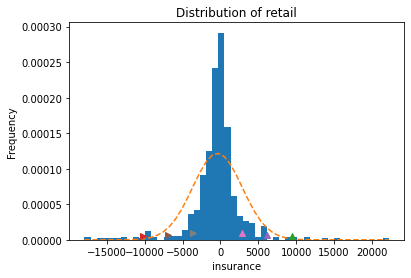

In [45]:
retail = df['insurance']
mu = retail.mean()
sigma = retail.std()

nbins = 50
n, bins, patches = plt.hist(retail, bins = nbins, density = 1)
plt.xlabel("insurance")
plt.ylabel("Frequency")
plt.title("Distribution of retail")
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
# plt.plot(bins, y, '--' )
plt.plot(bins, y, '--', mu+3*sigma, 0.5e-5, '^', mu-3*sigma, 0.5e-5, '>' )
plt.plot( mu+2*sigma, 0.7e-5, '^', mu-2*sigma, 0.7e-5, '>' )
plt.plot( mu+1*sigma, 0.9e-5, '^', mu-1*sigma, 0.9e-5, '>' )
plt.show()

In [ ]:
plt.plot(mu+sigma, 1, '^')

In [ ]:
i=0
x = df['retail'][i:i+20]
i=2
y = df['retail'][i:i+20]
r = np.arange(20)
plt.plot(r, x)
plt.plot(r, y)

In [ ]:
np.arange(1, 21)

In [ ]:
for i in range(100-18):
    print(i, i+19)

In [ ]:
print(df.rolling(window=3).sum()) # 뒤에 추가 메서드를 이용하여 연산을 지정해주어야합니다.

In [ ]:
print(df.rolling(window=4, closed='left').sum())

In [ ]:
print(df.rolling(window=2, closed='right').sum())

In [ ]:
dict_test = {
    'col1': [1, 1, 2, 2, 3, 3, 3, 4],
    'col2': [1000, 1100, 2100, 2050, 3000, 3100, 3200, 4200],
    'col3': ['a', 'b', 'a', 'c', 'a', 'a', 'd', 'e']}

In [ ]:
df_test = pd.DataFrame(dict_test)

In [ ]:
df_test

In [ ]:
df_test[['col2']].rolling(3).sum()

In [ ]:
df_test[['col2']].rolling(3, center=True).sum()

In [ ]:
df_test.rolling(3, on= 'col2', center=True).sum()

In [ ]:
df_test[['col2']].rolling(3, min_periods=1, center=True).sum()

In [ ]:
df_test[['col2']].rolling(3, closed='left').sum()

In [ ]:
df_test[['col2']].rolling(3, closed='right').sum()

In [ ]:
df_test = df_test.groupby(by=['col1', 'col3'])['col2'].apply(list)

In [ ]:
df_test = pd.DataFrame(df_test)

In [ ]:
df_test

In [ ]:
df_test.reset_index(drop=False, inplace=True)

In [ ]:
df_test

In [ ]:
df_test.set_index(keys=['col1', 'col3'], inplace=True)

In [ ]:
df_test.reset_index(['col1'], inplace=True)